In [1]:
#import packages
import numpy as np
import scipy as scp
import scipy.linalg as lng
from numba import njit, prange
import pickle
from matplotlib import pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.getcwd()+"/code"))
from pyStarlet_master_2D1D import * #2D1D Wavelet code
from HIFReD import FUSION # Fusion code
import warnings

from ipywidgets import interact, fixed
from tqdm.notebook import  tqdm,trange

Numba imported


### Importing toy models

*(made using hydrodynamic simulations by Orlando, S., Miceli, M., Pumo,
M. L., & Bocchino, F. 2016, The Astrophysical Journal, 822, 22)*

In [16]:
Toy_models={}
for k in ['Gaussian_1keV', 'Gaussian_6keV', 'Gaussian_1keV_Rebin', 'Realist_1keV_Rebin']:
    Toy_models[k]={}
    for kk in ['E_z', 'E_x', 'Z_gt', 'X_gt', 'Y_gt', 'X', 'Y', 'kernel2D_Y', 'kernel1D_X', 'ARF_Z', 'ARF_X', 'ARF_Y']:
        with open(f"toy_models/Toymodel_{k}_{kk}.p","rb") as f:
            Toy_models[k][kk]=pickle.load(f)

**Possible Toy models (see Lascar J. 2024 for detail):**

In [3]:
Toy_models.keys()

dict_keys(['Gaussian_1keV', 'Gaussian_6keV', 'Gaussian_1keV_Rebin', 'Realist_1keV_Rebin'])

**Each contains:**

In [4]:
Toy_models['Gaussian_1keV'].keys()

dict_keys(['E_z', 'E_x', 'Z_gt', 'X_gt', 'Y_gt', 'X', 'Y', 'kernel2D_Y', 'kernel1D_X', 'ARF_Z', 'ARF_X', 'ARF_Y'])

- X: Hyperspectral data with the best SPATIAL resolution (here, XMM-Newton)
- Y: Hyperspectral data with the best SPECTRAL resolution (here, XRISM)
- Z_gt: Ground truth of Z, the cube we try to recover
- X_gt: Ground truth of X (with no poisson noise)
- Y_gt: Ground truth of Y (with no poisson noise)
- E_z: Energy channels for Z and Y
- E_x: Energy channels for X (only different if X has a different voxel size, i.e. models with rebinning)
- kernel2D_Y: Point-spread function of Y
- kernel1D_X: Spectral response of X
- ARF_Z: Virtual effective area of Z
- ARF_X: Effective area of X
- ARF_Y: Effective area of Y

### Hyperspectral Fusion

**Possible Regularization Terms:**

- "Wavelet_2D_1D": l1 sparsity under the 2D-1D Starlet transform.
- "Low_rank_Sobolev": Spectral low rank approximation with Sobolev spatial regularisation.
- "Low_rank_Wavelet_2D": Spectral low rank approximation with l1 sparsity under the 2D Starlet transform.
- "Low_rank": Spectral low rank approximation.
- "None": No regularisation at all.

X has 60 spectral channels, and 45x45 pixels.
Y has 2400 spectral channels, and 15x15 pixels.
Using subspace projection.
Pre-defined rank:  10
with rebinning


Loss:   0%|          | 0/5 [00:00<?, ?it/s]

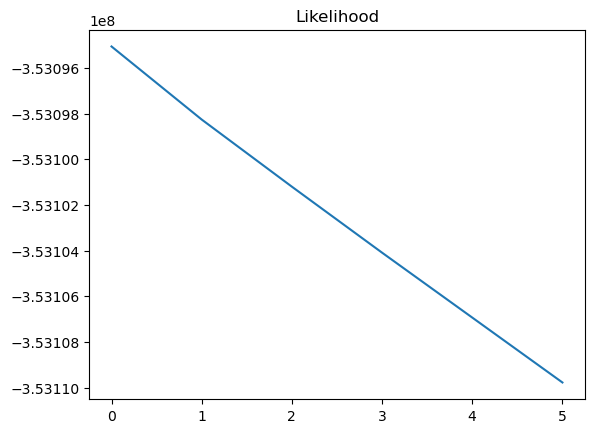

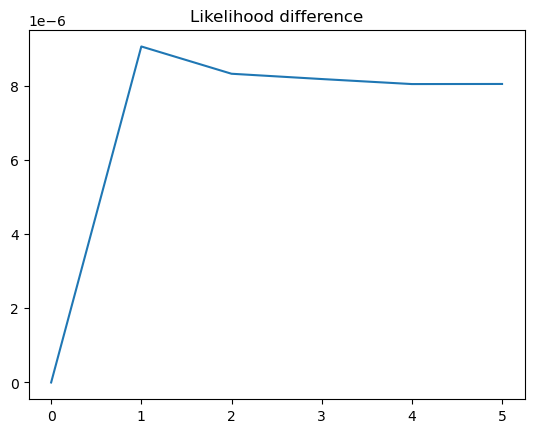

In [11]:
Model="Realist_1keV_Rebin"
Reg="Low_rank_Sobolev"
Result=FUSION(Toy_models[Model]["X"],Toy_models[Model]["Y"],
            kernel2D=Toy_models[Model]["kernel2D_Y"],
            kernel1D=Toy_models[Model]["kernel1D_X"],
            first_Z=None,
            ARF_X=Toy_models[Model]["ARF_Z"],
            ARF_Y=Toy_models[Model]["ARF_Y"],
            ARF_Z=Toy_models[Model]["ARF_X"],
            i_max=50000,
            alpha=0.01,
            spat_reg=Reg,
            mu_D=0.01,
            rank=10,
            kmad_var=True,
            kmin=0.5,
            kmad=3,
            J_1D=2,
            J_2D=3,
            it_save=100,
            keep_track=False,
            para_workers=4,
            vocal=True,
            fname=f'fusion_save_{Model}')


In [14]:
Z=Result[0] # the fusion result
Likelihood=Result[1] # the likelihood over iterations